# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [31]:
# TODO: load the air temperature and precipitation datasets. - DONE
air = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc', chunks={"time": 8})
precip = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc', chunks={"time": 8})
#raise NotImplementedError("Assign datasets to `air` and `precip`.")
print(precip)

<xarray.Dataset> Size: 379MB
Dimensions:  (time: 366, lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    precip   (time, lat, lon) float32 379MB dask.array<chunksize=(8, 360, 720), meta=np.ndarray>
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  tim

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [32]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed. -DONE
print(LAT_RANGE) # Wrong order!
print(LON_RANGE_360)
air_us = air['air'].sel(lat=slice(LAT_RANGE[1],LAT_RANGE[0]),lon=slice(LON_RANGE_360[0],LON_RANGE_360[1]),time=TIME_RANGE)
precip_us = precip['precip'].sel(lat=slice(LAT_RANGE[1],LAT_RANGE[0]),lon=slice(LON_RANGE_360[0],LON_RANGE_360[1]),time=TIME_RANGE)
#raise NotImplementedError("Create `air_us` and `precip_us`.")


(20, 50)
(230, 300)


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [33]:
# TODO: use xr.resample to create daily means. -DONE
air_daily = air_us.resample(time='D').mean()
precip_daily = precip_us.resample(time='D').sum()
#raise NotImplementedError("Create `air_daily`.")


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [35]:
# TODO: interpolate the resampled temperature field onto the precipitation grid. - DONE
air_interp = air_daily.interp(lat=precip_us.lat,lon=precip_us.lon)
#raise NotImplementedError("Create `air_interp`.")


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [36]:
# TODO: build datasets and merge them into one object named `merged`. - DONE
air_temp_ds = air_interp.to_dataset(name='air_temperature')
precip_ds = precip_daily.to_dataset(name='daily_precip')
merged = xr.merge([air_temp_ds,precip_ds])
#raise NotImplementedError("Create `merged`.")


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [37]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


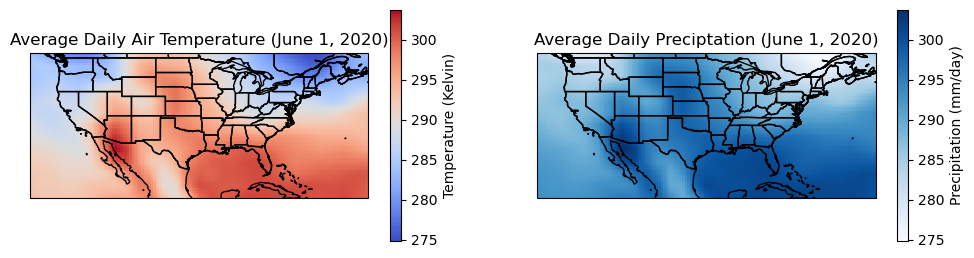

In [49]:
# Making the cartopy maps (one for each variable)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

merged.air_temperature.isel(time=0).plot(
    ax=ax1, 
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={'label': 'Temperature (Kelvin)','shrink':0.25} # Shrinking the cbar because otherwise it's massive
    )

ax1.set_title('Average Daily Air Temperature (June 1, 2020)')
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

merged.air_temperature.isel(time=0).plot(
    ax=ax2, 
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    cbar_kwargs={'label': 'Precipitation (mm/day)','shrink':0.25} # Shrinking the cbar because otherwise it's massive
    )

ax2.set_title('Average Daily Preciptation (June 1, 2020)')
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES)


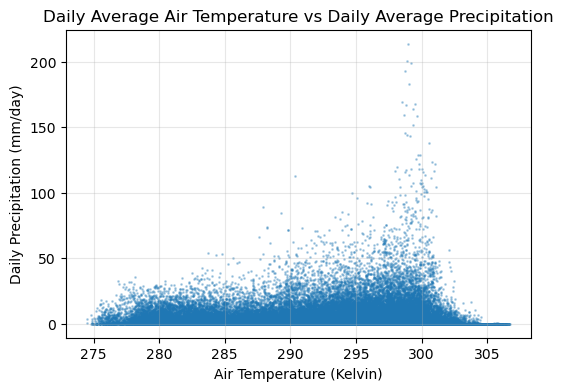

In [50]:
# Building the scatterplot
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(merged['air_temperature'], merged['daily_precip'], alpha=0.3, s=1)
ax.set_title('Daily Average Air Temperature vs Daily Average Precipitation')
ax.set_xlabel('Air Temperature (Kelvin)')
ax.set_ylabel('Daily Precipitation (mm/day)')
ax.grid(True, alpha=0.3)
